# Cook's membrane

In [1]:
import numpy as np
import pandas as pd
import altair as alt
import pyvista as pv
import deepxde as dde

from pinnDSE.geom import *
from pinnDSE.viz import *
from pinnDSE.elasticity import *
from pinnDSE.bc import *

# --UNITS--
# displacement: mm
# stress: MPa
# force: N
# E = 2e5 MPa (AISI Carbon Steel)
# nu = 0.27
# rho = 7.85e-3 
# yield = 490 MPa

Using TensorFlow 2 backend.

Instructions for updating:
non-resource variables are not supported in the long term


2 read mesh: 0.015621423721313477


3 coordinate transform: 2.4998443126678467
2 read results: 3.4167802333831787
1 total mesh and result loading: 3.5502214431762695
1 total edge processing: 0.15199971199035645


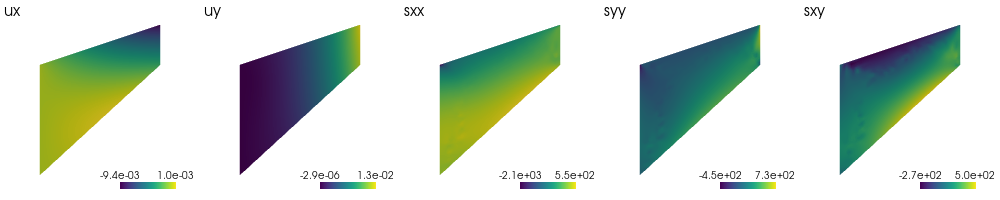

In [2]:
op2File = 'data/cooksMembrane/v1.0/cooksMembrane02.op2'
geom = MeshGeom(op2File, thickness=1.0)
plotScalarFields(geom.mesh, geom.resDf)

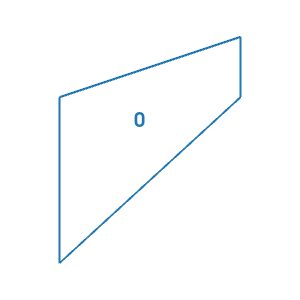

In [3]:
drawBoundaries(geom.bndDict)

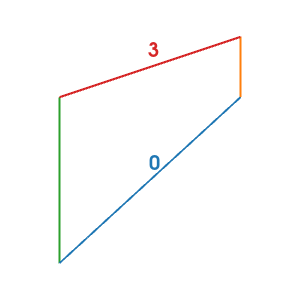

In [4]:
# by default every continuous edge forms a single boundary. We can further split the boundary like this
mask = getCellMask(geom.bndDict[0], component=0, func=lambda x: (x[:,0]>0.68).all())
newBndDict, newBndNormsDict = splitBoundary(geom.bndDict, geom.bndNormsDict, 0, mask)

mask = getCellMask(newBndDict[0], component=0, func=lambda x: (x[:,0]<-0.5).all())
newBndDict, newBndNormsDict = splitBoundary(newBndDict, newBndNormsDict, 0, mask)

mask = getCellMask(newBndDict[0], component=0, func=lambda x: (x[:,1]>0.24).all())
newBndDict, newBndNormsDict = splitBoundary(newBndDict, newBndNormsDict, 0, mask)

drawBoundaries(newBndDict)

In [5]:
# now update the boundary metadata
geom.bndDict, geom.bndNormsDict = newBndDict, newBndNormsDict
geom.updateBndLengthAndArea()

Compiling model...
Building feed-forward neural network...
'build' took 0.046863 s



C:\Users\ewhalen\Miniconda3\envs\pinnDSE\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
C:\Users\ewhalen\Miniconda3\envs\pinnDSE\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 0.954399 s

Initializing variables...
Training model...

Step      Train loss                                                                                                                            Test loss                                                                                                                             Test metric
0         [1.02e+03, 1.03e+01, 3.16e+04, 4.77e+05, 2.09e+03, 3.76e-09, 2.17e-06, 2.22e+02, 3.57e+02, 6.67e+02, 6.22e+06, 1.24e+02, 4.27e+02]    [1.05e+03, 9.82e+00, 3.28e+04, 4.93e+05, 2.11e+03, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  

Best model at step 0:
  train loss: 6.74e+06
  test loss: 5.29e+05
  test metric: []

'train' took 0.157939 s

Compiling model...
'compile' took 0.650268 s

Initializing variables...
Training model...

Step      Train loss                                                                                                                            Test los

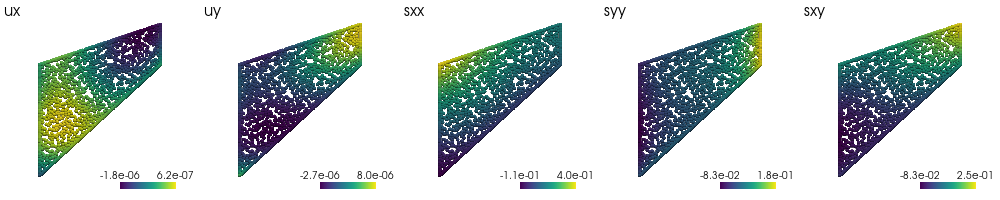

In [6]:
## train a pinn

# supports
xSup = SupportBC(geom, bndId=2, U=0, component=0)
ySup = SupportBC(geom, bndId=2, U=0, component=1)

# free edges
xTr0 = TractionBC(geom, bndId=0, T=0, component=0)
yTr0 = TractionBC(geom, bndId=0, T=0, component=1)

xTr3 = TractionBC(geom, bndId=3, T=0, component=0)
yTr3 = TractionBC(geom, bndId=3, T=0, component=1)

# loaded edges
xTr1 = TractionBC(geom, bndId=1, T=0, component=0)
yTr1 = TractionBC(geom, bndId=1, T=1000/geom.bndAreaDict[1], component=1)

# problem setup
# bndNumSamplesDir = {0: 800, 1: 200, 2: 200, 3: 200, 4: 200, 5: 200}
bndNumSamplesDir = {bndId:int(l*200) for bndId,l in geom.bndLensDict.items()}
paramDict = {'E':2e5, 'nu':0.3}
bcList = [xSup,ySup,xTr0,yTr0,xTr1,yTr1,xTr3,yTr3]
data = StrctPDE(geom, 
            elasticityEqs, 
            bcList, 
            num_domain=1000, 
            num_boundary_dir=bndNumSamplesDir, 
            num_test=500,
            paramDict=paramDict)

for bc in bcList:
    if isinstance(bc, TractionBC): 
        bc.train_n = data.train_n

# build model
net = dde.maps.FNN([2] + [64]*4  + [5], "tanh", "Glorot uniform")
outScales = np.array([1e-3, 1e-2, 1e2, 1e2, 1e2]) # [ux,uy,sxx,syy,sxy]
net.apply_output_transform(lambda x,y : y*outScales) 
model = dde.Model(data, net)

# get the unweighted loss values
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=0)
lw = losshistory.loss_train[0]**(-1) 

# train
model.compile("adam", lr=0.001, loss_weights=lw)
losshistory, train_state = model.train(epochs=1000, display_every=100)

# test
pred = model.predict(data.train_x)
predDf = pd.DataFrame(pred, columns=['ux', 'uy', 'sxx', 'syy', 'sxy'])
pc = pv.PolyData(addZ(data.train_x))
plotScalarFields(pc, predDf)

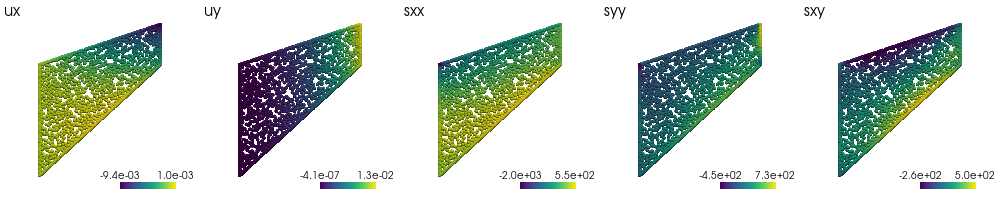

ux     0.190689
uy     0.274513
sxx    0.206311
syy    0.266245
sxy    0.444726
dtype: float32

In [7]:
intResDf = geom.sampleRes(data.train_x).drop(columns='vonMises')
plotScalarFields(pc, intResDf)

errors = predDf-intResDf
maxes = pd.concat([intResDf, predDf]).abs().max()
MAE = errors.abs().mean()
RMAE = MAE/maxes
RMAE

In [8]:
bcNames = ['xSup','ySup','xTr0','yTr0','xTr1','yTr1','xTr3','yTr3']
# lines = alt.Chart(pd.DataFrame({'step':[1000,3000,4000]})).mark_rule(color='gray').encode(x='step:Q')
lossPlot(losshistory, bcNames)

alt.Chart(...)

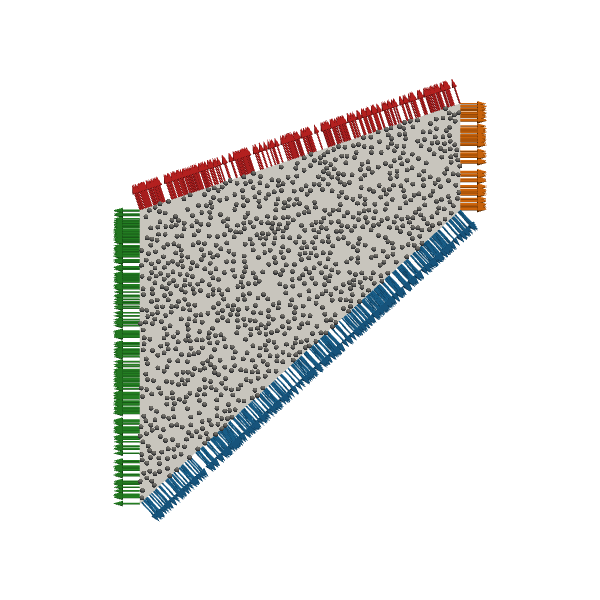

In [9]:
plotter = pv.Plotter(border=False)
plotter.set_background('white')
plotter.add_mesh(geom.mesh, show_edges=False)

# domain samples
pc = pv.PolyData(addZ(data.domainSamples))
plotter.add_mesh(pc, render_points_as_spheres=True, color='gray')

# boundary samples
for bndId, color in zip(geom.bndDict.keys(), CATEGORY10):
    samples = addZ(data.bndSampleDict[bndId])
    normals = addZ(data.bndNormalsDict[bndId])
    plotter.add_arrows(samples, normals, 0.1, color=color)
plotter.show(window_size=(600,600), cpos='xy');

In [13]:
data.train_x

array([[-0.51110972, -0.39671795],
       [-0.51110972, -0.57274229],
       [-0.51110972, -0.50345465],
       ...,
       [-0.48604268,  0.25686137],
       [-0.35743899,  0.29972919],
       [ 0.50095461,  0.58586048]])

In [15]:
data.train_y == None

True